In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

## Step 1: Camera calibration

Compensate distortion and other effects with the chessboard-calibration-image.
Make a list of all calibration images and calculate the camera matrix and distortion coefficients.

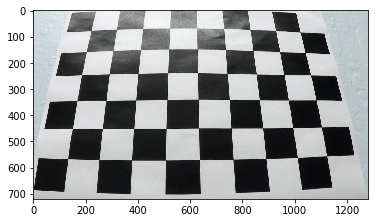

In [2]:
# Load calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Display a nice example calibration image
exs_img = cv2.imread(fnames[13])
plt.imshow(exs_img)

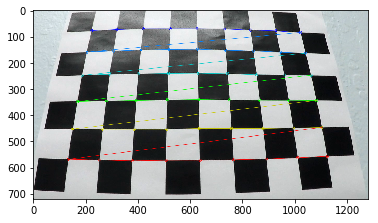

In [3]:
# Array to store object-points and image-points from the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image space

chessb_size_x = 9
chessb_size_y = 6
objp = np.zeros((chessb_size_x*chessb_size_y,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for i, fname in enumerate(fnames):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find corners of the Chessboard
    ret, corners = cv2.findChessboardCorners(gray, (chessb_size_x,chessb_size_y), None)

    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw first image as example
        if i==13:
            img = cv2.drawChessboardCorners(img, (chessb_size_x,chessb_size_y), corners, ret)
            plt.imshow(img)

# Get calibration parameter
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

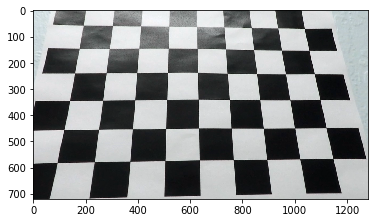

In [4]:
# Display undistorted example images
udst_img = cv2.undistort(exs_img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calib_undistorted.jpg', udst_img)
plt.imshow(udst_img)

# Step 2: Process Pipeline

### Undistort and make binary

First undistort a given image and generate a binary-image based on color-threholds (in HLS and HSV color-space), followed by gradient-magnitude and direction thresholds.

In [5]:
def preprocess_image(img, mtx, dist):
    
    # Parameters to tweak:
    s_col_thresh = (100, 255)
    v_col_thresh = (50, 255)
    sobel_kernel = 9
    mag_thresh = (25,150)
    dir_thresh = (0.5, 1.4) # between 0 and pi/2
    
    # Undistort with calibration-parameters
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to HLS space
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2] # get only saturation channel
    # Convert to HSV space
    hsv = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
    V = hsv[:,:,2] # get only value channel
    
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Calculate direction gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply all thresholds and create binary output
    binary = np.zeros_like(S)
    binary[(S > s_col_thresh[0]) & (S <= s_col_thresh[1]) &
           (V > v_col_thresh[0]) & (V <= v_col_thresh[1]) &
           ( ((gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])) |
             ((direction >= dir_thresh[0]) & (direction <= dir_thresh[1])) )] = 1
    
    return binary
    

In [6]:
####### Test output
test_img = cv2.imread('test_images/test1.jpg')
#test_img = cv2.imread('test_images/straight_lines1.jpg')

udst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('output_images/example_undist.jpg', udst)

test_binary = preprocess_image(test_img, mtx, dist)
test_binary[test_binary >= 1] = 255
cv2.imwrite('output_images/example_binary.jpg', test_binary)
#plt.imshow(test_binary, cmap='gray')
#####################

True

### Perspective Transform

Seccond apply a perspective transform. Lane lines are better extracted from the bird-eye-perspective.

In [7]:
def perspective_transform(img, reverse=False):
    # Define source points. These were specified by hand from an example image with a straight road
    src = np.float32([[570,460], [720,460], [1150,720], [170,720]])
    offset = 100
    dst = np.float32([[offset,0],
                      [img.shape[1]-offset, 0],
                      [img.shape[1]-offset,img.shape[0]],
                      [offset,img.shape[0]]])
    
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped

In [8]:
####### Test output
points = np.array([[570,460], [720,460], [1150,720], [170,720]])
poly = test_img.copy()
cv2.polylines(poly, np.int32([points]), 1, (0,0,255), 3)
cv2.imwrite('output_images/bird_eye_orig.jpg',poly)
#plt.subplot(221)
#plt.tight_layout()
#plt.imshow(cv2.cvtColor(poly, cv2.COLOR_BGR2RGB))

warped = perspective_transform(poly)
cv2.imwrite('output_images/bird_eye_warped.jpg',warped)
#plt.subplot(222)
#plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
test_binary_warped = perspective_transform(test_binary)
cv2.imwrite('output_images/bird_eye_binary.jpg',test_binary_warped)
#plt.subplot(223)
#plt.imshow(test_binary_warped, cmap='gray')
######################

True

### Finding lane pixels and fit polynomial

In [9]:
class Line():
    # Number of fits/points/iterations which are tracked
    MAX_N = 15
    
    
    
    def __init__(self):
        # Detect first of all runs to skip certain checks
        self.first_run = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients of the last n iterations
        self.recent_fits = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def search_line_in_warped_img(self, binary_warped_img, is_left=True):
        if self.detected:
            # Line was detected previously so just try to infer the position based on the one from last iteration
            # Function returns false if it wont find any px
            if not self.__infer_line_from_last(binary_warped_img):
                if not self.__find_fresh_line(binary_warped_img, is_left):
                    # Either function could find a line!
                    # Just keep values unchanged from last iteration.
                    self.detected = False
                else:
                    self.detected = True
            else:
                self.detected = True
        else:
            if not self.__find_fresh_line(binary_warped_img, is_left):
                self.detected = False
            else:
                self.detected = True
        
    def __find_fresh_line(self, binary_warped_img, is_left):
        histogram = np.sum(test_binary_warped[binary_warped_img.shape[0]//2:,:], axis=0)
        # Find the peak of either left or right halves of the histogram
        midpoint = np.int(histogram.shape[0]/2)
        if (is_left):
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
    
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped_img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive lane pixel indices
        lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low  = binary_warped_img.shape[0] - (window+1)*window_height
            win_y_high = binary_warped_img.shape[0] - window*window_height
            win_x_low  = x_current - margin
            win_x_high = x_current + margin
        
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))
        
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        # Extract line pixel positions
        if len(lane_inds) != 0:
            x = nonzerox[lane_inds]
            y = nonzeroy[lane_inds]
            # Check for empty vectors
            if (len(x) == 0) or (len(y) == 0):
                return False
            # Fit a second order polynomial
            fit = np.polyfit(y, x, 2)
            # Generate x y values from fit coefficients
            ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0])
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
            radius = self.__calc_radius(fitx, ploty)
            # Sanity Check radius
            if (radius < 100) or (radius > 10000):
                success = False
            else:
                # Sanity Check for coefficient difference
                if (not self.first_run) and (np.max(np.absolute(self.current_fit - fit)) > 1000):
                    success = False
                else:
                    success = True
                    if self.first_run:
                        self.first_run = False
                    self.__update_vars(True, fit, fitx, radius, x, y)
        else:
            success = False
        
        return success
        
        
    def __infer_line_from_last(self, binary_warped_img):
        nonzero = binary_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        line_inds = ((nonzerox > (self.current_fit[0]*(nonzeroy**2) +
                                  self.current_fit[1]*nonzeroy +
                                  self.current_fit[2] - margin)) &
                     (nonzerox < (self.current_fit[0]*(nonzeroy**2) +
                                  self.current_fit[1]*nonzeroy +
                                  self.current_fit[2] + margin)))

        # Check if any indexes were found
        if len(line_inds) == 0:
            return False
        else:
            x = nonzerox[line_inds]
            y = nonzeroy[line_inds]
            # Check for empty vectors
            if (len(x) == 0) or (len(y) == 0):
                return False
            fit = np.polyfit(y, x, 2)
            # Generate x y values from fit coefficients
            ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0])
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
            radius = self.__calc_radius(fitx, ploty)
            # Sanity Check radius
            if (radius < 100) or (radius > 10000):
                return False
            # Sanity Check for coefficient difference
            if np.max(np.absolute(self.current_fit - fit)) > 700:
                return False
            self.__update_vars(True, fit, fitx, radius, x, y)
            
        return True
    
    
    def __update_vars(self, detected, fit, fitx, radius, x, y):
        # Update member vars
        self.detected = detected
        self.diffs = self.current_fit - fit 
        self.__add_xfitted(fitx)
        self.__add_fit(fit)
        self.radius_of_curvature = radius
        self.line_base_pos = np.average(self.bestx)
        self.allx = x
        self.ally = y
        
        
    def __add_xfitted(self, fitx):
        self.recent_xfitted.append(fitx)
        if len(self.recent_xfitted) > self.MAX_N:
            self.recent_xfitted = self.recent_xfitted[1:]
        # Update average
        self.bestx = np.average(self.recent_xfitted, axis=0)
            
            
    def __add_fit(self, fit):
        self.current_fit = fit
        self.recent_fits.append(fit)
        if len(self.recent_fits) > self.MAX_N:
            self.recent_fits = self.recent_fits[1:]
        # Update average
        self.best_fit = np.average(self.recent_fits, axis=0)
            
            
    def __calc_radius(self, plotx, ploty):
        # Define y-value where we want radius of curvature
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        # Now our radius of curvature is in meters
        return curverad
    

In [10]:
# Create output image to draw on 
out_img = np.stack((test_binary_warped, test_binary_warped, test_binary_warped))*255

left_lane = Line()
right_lane = Line()

left_lane.search_line_in_warped_img(test_binary_warped, is_left=True)
right_lane.search_line_in_warped_img(test_binary_warped, is_left=False)

# Color left and right pixels
for y,x in np.transpose(np.stack((left_lane.ally, left_lane.allx))):
    out_img[:, y, x] = [255, 0, 0]
for y,x in np.transpose(np.stack((right_lane.ally, right_lane.allx))):
    out_img[:, y, x] = [0, 0, 255]

# Generate y values for plotting
ploty = np.linspace(0, out_img.shape[1]-1, out_img.shape[1])
left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]

for y,x in np.transpose(np.stack((ploty, left_fitx))):
    out_img[:, int(y), int(x)] = [0, 255, 255]
for y,x in np.transpose(np.stack((ploty, right_fitx))):
    out_img[:, int(y), int(x)] = [0, 255, 255]

out_img = np.swapaxes(out_img, 0, -1)
out_img = np.swapaxes(out_img, 0, 1)
cv2.imwrite('output_images/lane_px_with_fit.jpg', out_img)

True

### Draw results back onto image

In [11]:
def draw_lines_to_img(undist, warped, left_line, right_line, debug_print=False):
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    #for point in np.int_(pts[0]):
    #    cv2.circle(color_warp, (point[0],point[1]), 20, (0,255,0), 5)
    # Mark detected pixel
    color_warp[right_line.ally, right_line.allx] = [255, 0, 255]
    color_warp[left_line.ally, left_line.allx] = [0, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, True) 
    if debug_print:
        # Print debug information
        string = []
        for (name, side) in (("Right", right_line), ("Left", left_line)):
            #string.append(name+" line Class:")
            #string.append("best_fit="+str(side.best_fit))
            string.append(name+"curve="+str(round(side.radius_of_curvature,2))+"m")
            #string.append("detected="+str(side.detected))
            #string.append("fit_diff="+str(side.diffs))
            #string.append("diff_max="+str(np.max(np.absolute(side.diffs))))
            #string.append(" ")
        # Calculate car offset
        xm_per_px = 3.7/800
        midpoint_lane = (right_line.line_base_pos - left_line.line_base_pos)/2.
        pos_camera = 720/2
        car_offset = (pos_camera - midpoint_lane)*xm_per_px
        if car_offset <0:
            string.append("Vehicle is "+str(round(abs(car_offset),2))+"m on the right side from center.")
        else:
            string.append("Vehicle is "+str(round(abs(car_offset),2))+"m on the left side from center.")
    
        for i,text in enumerate(string):
            result = cv2.putText(undist, text, (50,50+(i*30)), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        
    else:
        result = undist
    # Combine the result with the original image
    result = cv2.addWeighted(result, 1, newwarp, 0.4, 0)
    
    return result

In [12]:
# process pipeline
def process_pipeline(image):
    global left_lane, right_lane
    global mtx, dist
    
    img_binary = preprocess_image(image, mtx, dist)
    img_binary_warped = perspective_transform(img_binary)
    
    left_lane.search_line_in_warped_img(img_binary_warped, is_left=True)
    right_lane.search_line_in_warped_img(img_binary_warped, is_left=False)

    return draw_lines_to_img(image, img_binary_warped, left_lane, right_lane, True)

In [13]:
#### Test output

for i in range(1,7):
    test_img = cv2.imread('test_images/test'+str(i)+'.jpg')
    left_lane = Line()
    right_lane = Line()

    result = process_pipeline(test_img)
    cv2.imwrite('output_images/test_with_lane_'+str(i)+'.jpg', result)

############

# Step 3: Process Video

In [14]:
from moviepy.editor import VideoFileClip

In [15]:
left_lane = Line()
right_lane = Line()

lane_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:38<00:00,  3.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 43s, sys: 1min 4s, total: 7min 48s
Wall time: 6min 40s
